# 数字信号处理

## 使用说明

1. 使用[Julia语言](https://cn.julialang.org/)编写代码，[Jupyter笔记本](https://jupyter.org/)作为交互界面；使用[nbviewer](https://nbviewer.jupyter.org/)进行[快速预览](https://nbviewer.jupyter.org/github/miRoox/HIT-DigitalSignalProcessing-Postgraduate/blob/master/work.ipynb?flush_cache=true)，[Binder](https://mybinder.org/)提供[在线交互](https://mybinder.org/v2/gh/miRoox/HIT-DigitalSignalProcessing-Postgraduate/master?filepath=work.ipynb)。
2. 在Jupyter笔记本中运行代码：选中要运行的代码块，按组合键 <kbd>Shift</kbd>+<kbd>Enter</kbd> 即可运行。也可以通过菜单栏的 "Cell" 下的 "Run Cells" 等菜单项来运行。
3. 首次运行代码时，Julia需要进行即时编译预热，响应速度会比较慢，再次运行速度就正常了。
4. [Binder](https://mybinder.org/)提供的在线交互是通过连接云服务器上运行的内核实现的，在长期不运行的情况下会连接超时，可以点击右边的[链接](https://mybinder.org/v2/gh/miRoox/HIT-DigitalSignalProcessing-Postgraduate/master?filepath=work.ipynb)重新进入。
5. 对于不是自己的笔记本，Jupyter总是把它们当作“不可信”的，这会导致输出的图像等不显示。可以通过菜单栏的 "File" 下的 "信任笔记" 以信任状态重新加载，这时输出的图像等内容就会完整的显示了。

载入包

* [Plots.jl](http://docs.juliaplots.org/latest/) - 绘图
* [Images.jl](https://juliaimages.org/latest/) - 图像处理
* [TestImages.jl](https://testimages.juliaimages.org/) - 测试图像
* [FFTW.jl](https://juliamath.github.io/FFTW.jl/latest/) - 快速傅里叶变换
* [Deconvolution.jl](https://juliadsp.github.io/Deconvolution.jl/dev/) - 反卷积

In [1]:
using Plots, Images, TestImages, FFTW, Deconvolution

运动模糊模型
$$
g(x,y)=f(x,y)*h(x,y)+n(x,y)
$$

其中，
$$
h(x,y)=\begin{cases}
        \frac{1}{L} & 0\le x\le L\cos\theta, 0\le y\le x\tan\theta\\
        0 & \text{其它}
    \end{cases}
$$

In [2]:
function motionPSF(l::Real,θ::Real)
    ker=centered(zeros((2*ceil.(Int,l.*abs.([sin(θ),cos(θ)])).+1)...))
    for i in 0:l
        ker[round.(Int,i.*[-sin(θ),cos(θ)])...]=1/l
    end
    ker
end

motionPSF (generic function with 1 method)

MSE

In [86]:
mse(a,b)=sum(abs2,a .- b)/prod(size(a))

mse (generic function with 1 method)

载入测试图像（原图像）

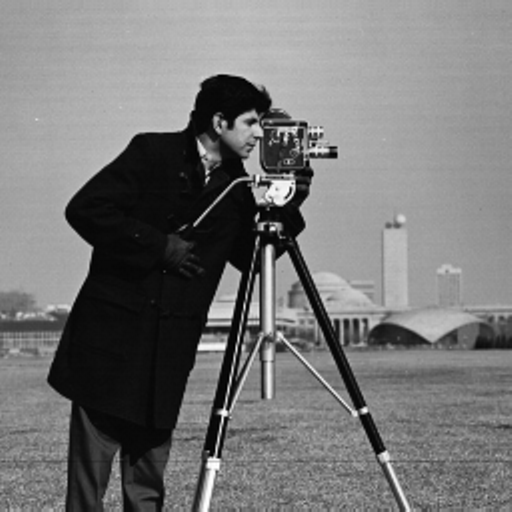

In [75]:
origin=testimage("cameraman")

加入运动模糊

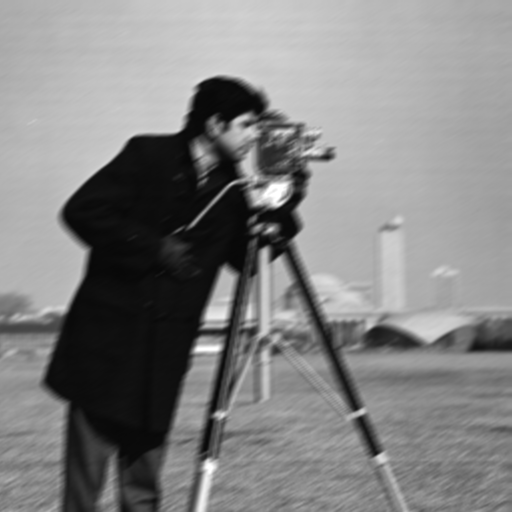

In [76]:
blurring=motionPSF(10,3π/18)
blurred=imfilter(origin,blurring)

加入噪声

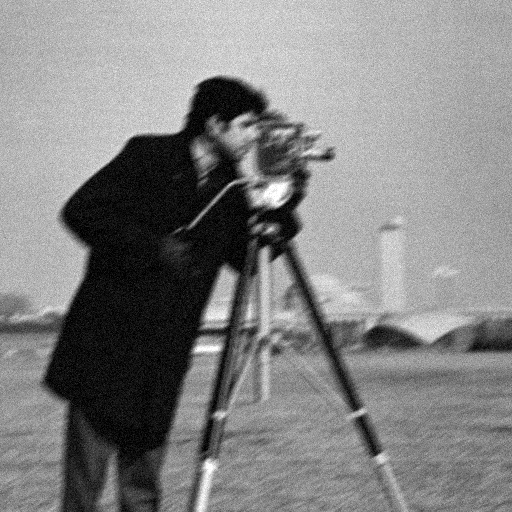

In [77]:
noise=randn(size(origin))./25;
blurred_n=Gray.(blurred.+noise)

填充模糊核至图像相同大小

In [80]:
blurring_p=zeros(size(origin))
blurring_p[(size(origin).÷2)...]=1
blurring_p=imfilter(blurring_p,blurring);

维纳滤波复原

$$
\hat{F}(u,v)=\left[\frac{1}{H(u,v)}\frac{|H(u,v)|^2}{|H(u,v)|^2+S_n(u,v)/S_f(u,v)}\right]
$$

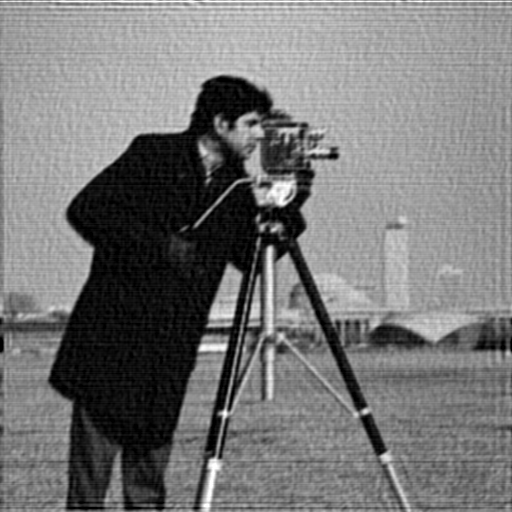

In [81]:
recovered=Gray.(fftshift(wiener(channelview(blurred_n),channelview(origin),noise,blurring_p)))

In [87]:
mse(origin,recovered)

0.0043128929798433675

直接逆滤波

In [ ]:
recover_i=Gray.(ifft(fft(channelview(blurred_n))./fft(blurring_p)))

加大噪声方差

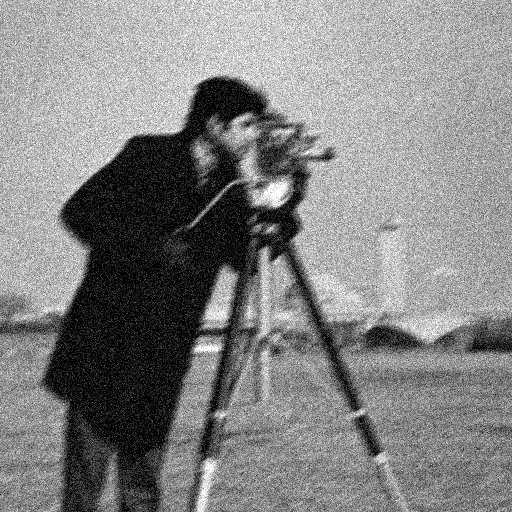

In [84]:
noise2=randn(size(origin))./10;
blurred_n2=Gray.(blurred.+noise2)

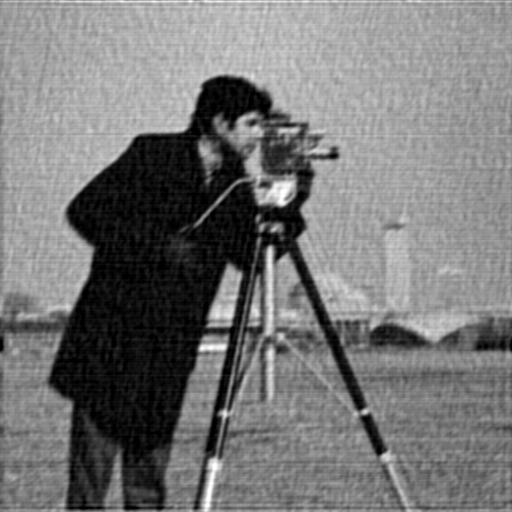

In [85]:
recovered2=Gray.(fftshift(wiener(channelview(blurred_n2),channelview(origin),noise2,blurring_p)))

In [88]:
mse(origin,recovered2)

0.0041486445193410874

不匹配的噪声估计（估计噪声方差偏小）

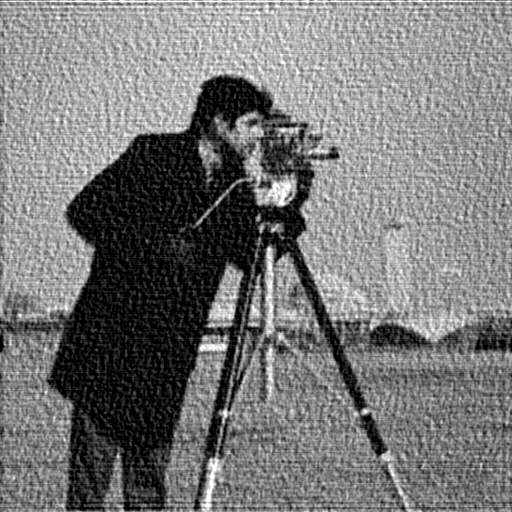

In [92]:
recovered3=Gray.(fftshift(wiener(channelview(blurred_n2),channelview(origin),noise,blurring_p)))

In [93]:
mse(origin,recovered3)

0.011798799639748808

不匹配的噪声估计（估计噪声方差偏大）

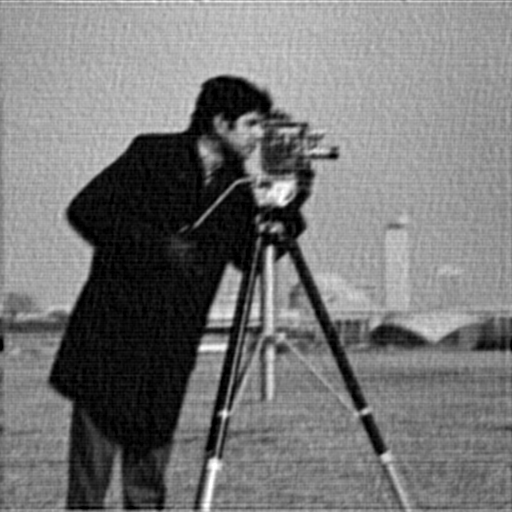

In [94]:
recovered4=Gray.(fftshift(wiener(channelview(blurred_n),channelview(origin),noise2,blurring_p)))

In [96]:
mse(origin,recovered4)

0.003874212632710895

## 参考文献

[1] 乐翔, 程建, 李民. 一种改进的基于Radon变换的运动模糊图像参数估计方法[J]. 红外与激光工程, 2011, 40(05): 963–969.

[2] MASTERS B R, GONZALEZ R C, WOODS R. Digital Image Processing, Third Edition[J]. Journal of Biomedical Optics, 2009, 14(2): 029901.